In [1]:
import re

import networkx as nx

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [47]:
g = nx.DiGraph()

In [50]:
state = 0
g.add_node(state)
bool(g.nodes)

True

In [3]:
class Token:
    
    def __init__(self, token, ignore_case=True, scrub_re='\.'):
        
        self.ignore_case = ignore_case
        self.scrub_re = scrub_re
        
        self.token = token
        self.token_clean = self._clean(token)
        
    def _clean(self, token):
        
        if self.ignore_case:
            token = token.lower()
            
        if self.scrub_re:
            token = re.sub(self.scrub_re, '', token)
            
        return token
    
    def __call__(self, input_token):
        return self._clean(input_token) == self.token_clean
    
    def __repr__(self):
        return '%s<%s>' % (self.__class__.__name__, self.token_clean)

In [84]:
class GeoFSA(nx.DiGraph):
    
    def __init__(self):
        super().__init__()
        
    def _next_state(self):
        state = max(self.nodes) + 1 if self.nodes else 0
        self.add_node(state)
        return state
        
    def add_token(self, accept_fn, parent=None, optional=False):
        
        s1 = parent if parent else self._next_state()
        s2 = self._next_state()
        
        self.add_edge(s1, s2, accept_fn=accept_fn)
        
        if optional:
            s3 = self._next_state()
            self.add_edge(s2, s3)
            self.add_edge(s1, s3)
            return s3
        
        return s2

In [85]:
class Matcher:
    
    def __init__(self, fsa):
        self.fsa = fsa
        self._states = set([0])
        self.accepted = []
        
    def step(self, start_state, token, visited=None):
        
        if not visited:
            visited = set()
            
        visited.add(start_state)
        
        next_states = set()
        for d_state, attrs in self.fsa[start_state].items():
            
            accept_fn = attrs.get('accept_fn')
            
            if accept_fn:
                if accept_fn(token):
                    next_states.add(d_state)
                    
            elif d_state not in visited: 
                next_states.update(self.step(d_state, token, visited))
                
        return next_states
        
    def __call__(self, token):
        
        next_states = set()
        for state in self._states:
            next_states.update(self.step(state, token))
            
        if next_states:
            self._states = next_states
            self.accepted.append(token)
            return True
        
        return False

In [88]:
title_tokens = ['South', 'Lake', 'Tahoe']
states = [['California'], ['CA']]

g = GeoFSA()

parent = None
for token in title_tokens:
    parent = g.add_token(Token(token), parent=parent)
    
comma = g.add_token(Token(','), parent=parent)

for state in states:
    parent = comma
    for token in state:
        parent = g.add_token(Token(token), parent=parent)

In [89]:
m = Matcher(g)
print(m('South'))
print(m('Lake'))
print(m('Tahoe'))
print(m(','))
# print(m(','))
# print(m(','))
print(m('CA'))

True
True
True
True
True


In [90]:
m.accepted

['South', 'Lake', 'Tahoe', ',', 'CA']

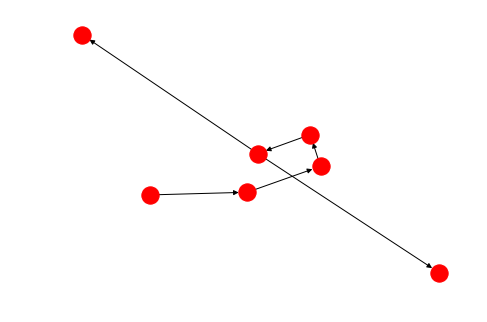

In [91]:
nx.draw(g)